Dataset : https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation

In [ ]:
import pandas as pd
import numpy as np

import re

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [ ]:
!pip install kneed

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import scipy.cluster.hierarchy as sch

try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator
#------------------------------------------------------------------
try:
    from yellowbrick.cluster import KElbowVisualizer
except:
    !pip install -U yellowbrick
    from yellowbrick.cluster import KElbowVisualizer

In [ ]:
try:
    import plotly.express as px
    import plotly.graph_objects as go

except:
    !pip install plotly
    import plotly.express as px
    import plotly.graph_objects as go


In [ ]:
data = pd.read_csv("/content/bank_transactions.csv")
data.head(5)

In [ ]:
#data = data.sample(frac=0.05, random_state=42)

In [ ]:
data.shape

(1048567, 9)

In [ ]:
## Show detailes data set
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check
check(data)

In [ ]:
data.dropna(subset=['CustLocation', 'CustomerDOB', 'CustAccountBalance'], inplace = True)
data.shape

(1042651, 9)

In [ ]:
check(data)

In [ ]:
data['CustGender'].value_counts()

M    760978
F    280635
T         1
Name: CustGender, dtype: int64

In [ ]:
data.fillna({
    "CustGender":"F"
}, inplace = True)


In [ ]:
data['CustGender'].value_counts()

M    760978
F    281672
T         1
Name: CustGender, dtype: int64

In [ ]:

data.isna().sum()

In [ ]:
#check for duplication
data.duplicated().sum()

0

In [ ]:
data['CustGender'].nunique()

3

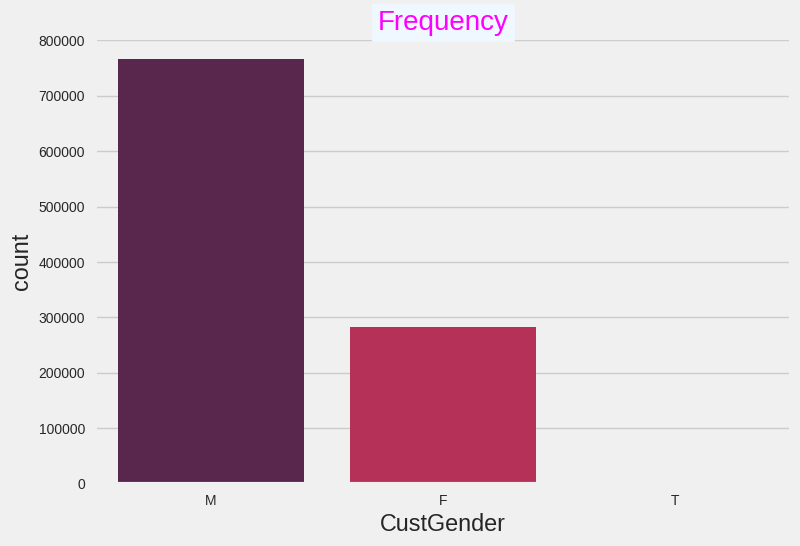

In [ ]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='CustGender',data=data,palette='rocket', order = data['CustGender'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [ ]:
import numpy as np

def dob_formatter(value):
    if pd.isna(value):  # Check if the value is NaN
        return np.NaN

    parts = value.split('/')  # Split the value by '/'
    if len(parts) != 3:  # Check if there are three parts (day, month, year)
        return np.NaN

    day, month, year = map(int, parts)  # Convert parts to integers

    # Handle two-digit years
    if len(parts[2]) == 2:
        year = int(parts[2])
        if year < 23:
            year += 2000  # Assume year is in the range 2000-2022
        else:
            year += 1900  # Assume year is in the range 1923-1999

    # Handle four-digit years
    if len(parts[2]) == 4:
        year = int(parts[2])

    return f"{year}/{month:02d}/{day:02d}"


data["CustomerDOB"] = data["CustomerDOB"].astype(str).apply(dob_formatter)



In [ ]:
data["CustomerDOB"] = pd.to_datetime(data["CustomerDOB"])
data["TransactionDate"] = pd.to_datetime(data["TransactionDate"])

from datetime import datetime

# Assuming data["CustomerDOB"] and data["TransactionDate"] are in datetime format
data["CustomerAge"] = datetime.now().year - data["CustomerDOB"].dt.year


In [ ]:
data["CustomerAge"]

In [ ]:
min(data["CustomerAge"])

8.0

In [ ]:
data.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)', 'CustomerAge'],
      dtype='object')

In [ ]:
#df['TransactionDate1'] ==> I will keep it to do visaulization
data['TransactionDate1']=data['TransactionDate'] # ==> to calculate the minimum (first transaction)
data['TransactionDate2']=data['TransactionDate'] # ==> to calculate the maximum (last transaction)

In [ ]:
#Creating RMF Table Strategy

RMF_data = data.groupby("CustomerID").agg({
                                        "TransactionID" : "count",
                                        "CustGender" : "first",
                                        "CustLocation":"first",
                                        "CustAccountBalance"  : "mean",
                                        "TransactionAmount (INR)" : "mean",
                                        "CustomerAge" : "max",
                                        "TransactionDate2":"max",
                                        "TransactionDate1":"min",
                                        "TransactionDate":"median"
                        })

RMF_data = RMF_data.reset_index()
RMF_data.head()

In [ ]:
RMF_data.shape

(880089, 10)

In [ ]:
RMF_data.drop(columns=["CustomerID"],inplace=True)

In [ ]:
RMF_data['Recency']=RMF_data['TransactionDate2']-RMF_data['TransactionDate1']

In [ ]:

RMF_data['Recency']=RMF_data['Recency'].astype(str)
RMF_data.head()

In [ ]:
RMF_data['Recency']=RMF_data['Recency'].apply(lambda x :re.search('\d+',x).group())
RMF_data['Recency']=RMF_data['Recency'].astype(int)

In [ ]:
#0 days mean that a customer has done transaction recently one time by logic so I will convert 0 to 1
def rep_0(i):
    if i==0:
        return 1
    else:
        return i
RMF_data['Recency']=RMF_data['Recency'].apply(rep_0)

In [ ]:
RMF_data.drop(columns=["TransactionDate1","TransactionDate2"],inplace=True)
RMF_data.head(3)

In [ ]:
RMF_data.rename(columns={"TransactionID":"Frequency"},inplace=True)

In [ ]:
# to claculate the outliers for each feature
lower_list=[]
upper_list=[]
num_list=[]
perc_list=[]
cols=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency']
for i in cols:
    Q1 = RMF_data[i].quantile(0.25)
    Q3 = RMF_data[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    # calculate number of outliers
    num=RMF_data[(RMF_data[i] < lower) | (RMF_data[i] > upper)].shape[0]
    # calculate percentage of outliers
    perc = (num / RMF_data.shape[0]) * 100
    lower_list.append(lower)
    upper_list.append(upper)
    num_list.append(num)
    perc_list.append(round(perc,2))


dic={'lower': lower_list, 'upper': upper_list, 'outliers': num_list, 'Perc%':perc_list }
outliers_df=pd.DataFrame(dic,index=['Frequency', 'CustAccountBalance','TransactionAmount (INR)', 'CustomerAge', 'Recency'])
outliers_df

,lower,upper,outliers,Perc%
Frequency,1.000,1.000,142192,16.16
CustAccountBalance,-78309.735,145393.905,116611,13.25
TransactionAmount (INR),-1385.250,2816.750,91880,10.44
CustomerAge,9.500,53.500,84956,9.65
Recency,1.000,1.000,136340,15.49


## EDA

In [ ]:
RMF_data.describe()

,Frequency,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
count,880089.000000,8.800890e+05,8.800890e+05,880089.000000,880089.000000
mean,1.184671,1.146073e+05,1.567088e+03,43.592459,15.886246
std,0.449129,8.007374e+05,6.432656e+03,45.997952,46.667884
min,1.000000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,1.000000,5.579130e+03,1.905000e+02,26.000000,1.000000
50%,1.000000,1.864037e+04,5.000000e+02,30.000000,1.000000
75%,1.000000,6.150504e+04,1.241000e+03,37.000000,1.000000
max,6.000000,1.150355e+08,1.560035e+06,216.000000,336.000000


<Axes: >

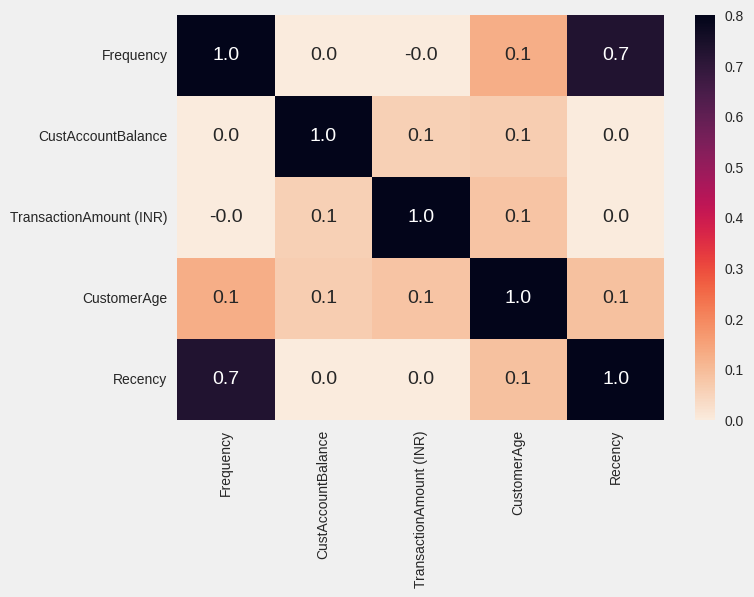

In [ ]:
# correlation between features
plt.figure(figsize=(7,5))
correlation=RMF_data.corr()
sns.heatmap(correlation,vmin=None,
    vmax=0.8,
    cmap='rocket_r',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True)

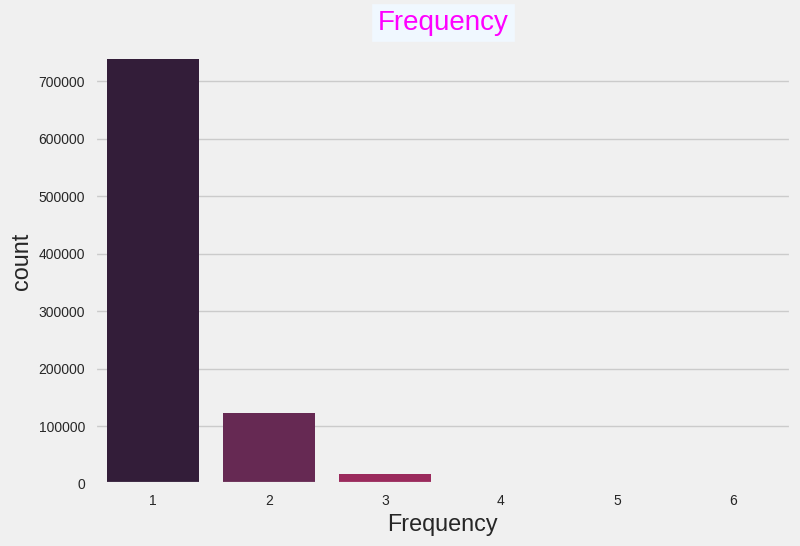

In [ ]:

plt.style.use("fivethirtyeight")
chart=sns.countplot(x='Frequency',data=RMF_data,palette='rocket', order = RMF_data['Frequency'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [ ]:
RMF_data['CustGender'].value_counts()

M    642152
F    237936
T         1
Name: CustGender, dtype: int64

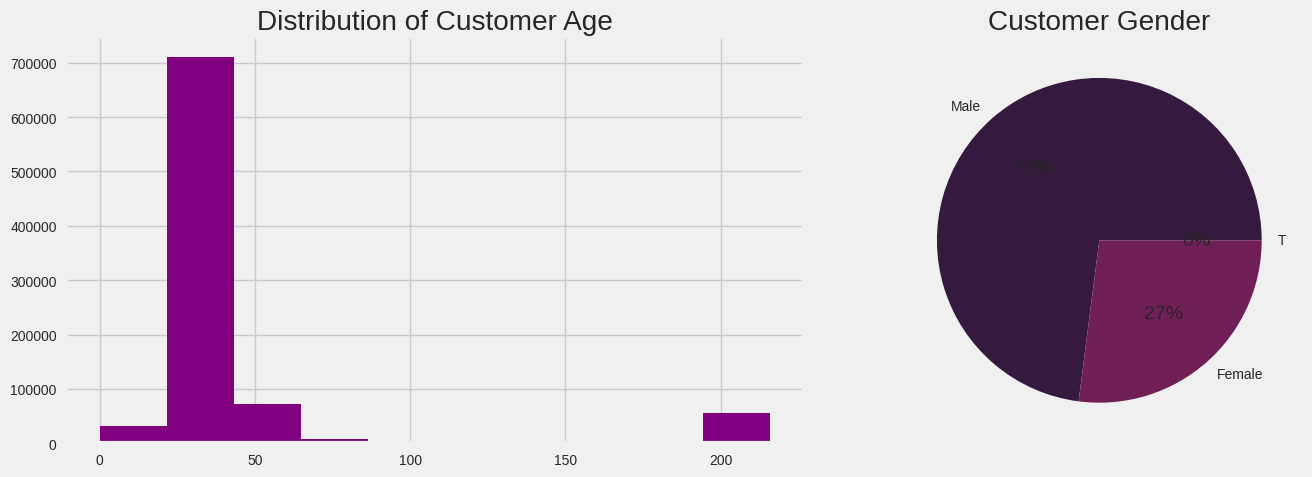

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=RMF_data['CustomerAge'],color='purple')
ax[0].set_title("Distribution of Customer Age")
ax[1].pie(RMF_data['CustGender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female','T'])
ax[1].set_title("Customer Gender")
plt.tight_layout();

In [ ]:
RMF_data[RMF_data["CustomerAge"] > 50].shape

(95142, 8)

In [ ]:
RMF_data.drop(RMF_data[RMF_data["CustomerAge"] > 50].index.tolist(), axis=0, inplace=True)

In [ ]:
RMF_data.shape

(784947, 8)

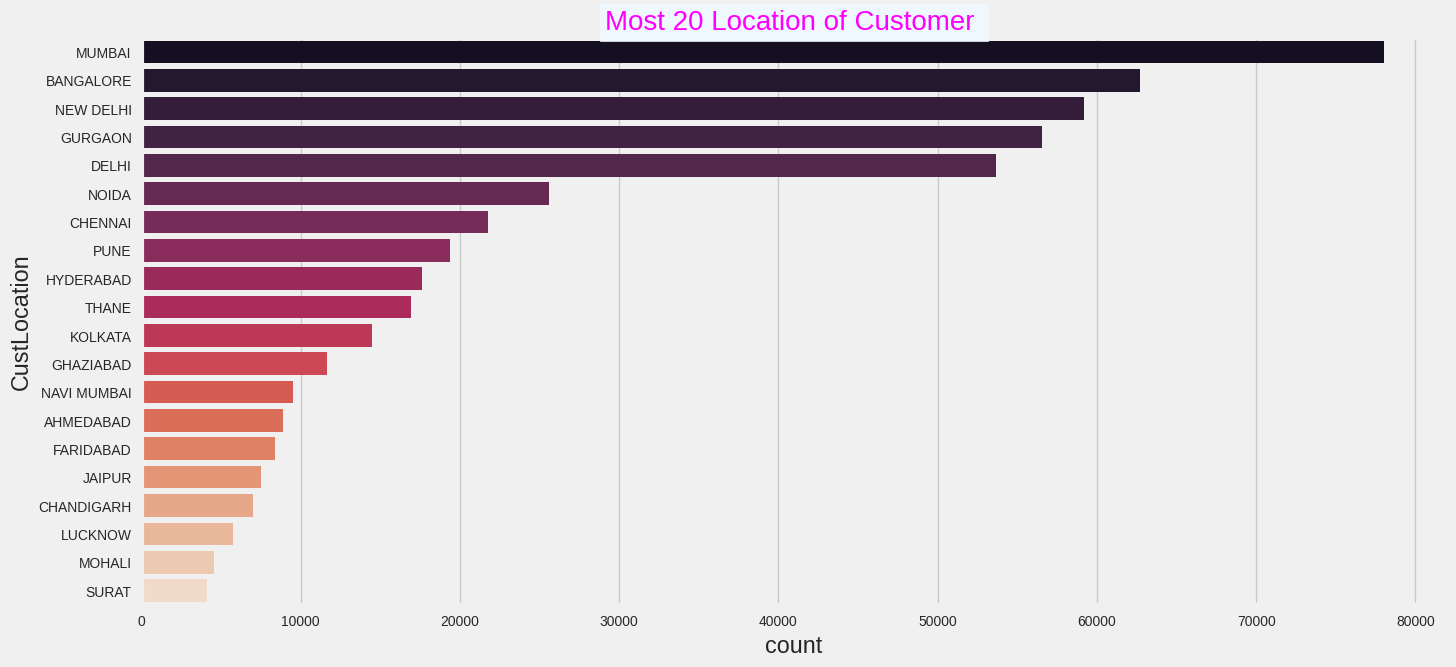

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='CustLocation',data=RMF_data,palette='rocket', order = RMF_data['CustLocation'].value_counts()[:20].index)
plt.title("Most 20 Location of Customer ",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

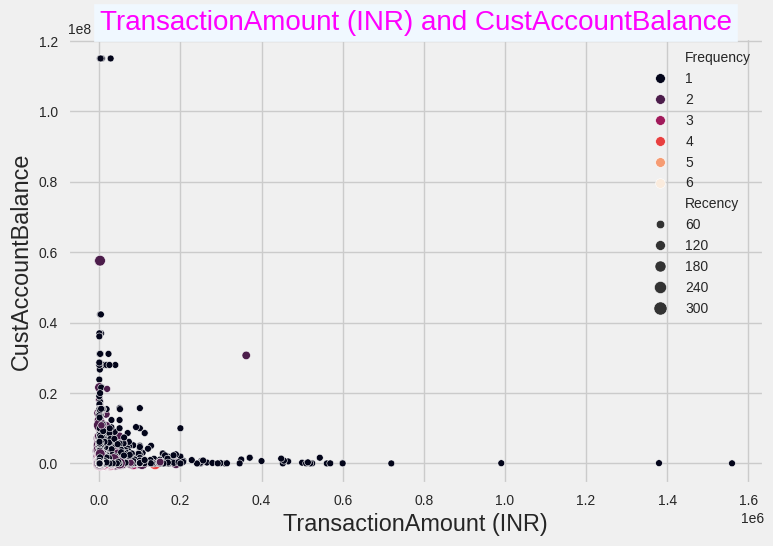

In [ ]:
plt.style.use("fivethirtyeight")
sns.scatterplot(x='TransactionAmount (INR)',y='CustAccountBalance',data=RMF_data,palette='rocket',hue='Frequency',size='Recency' )
plt.title("TransactionAmount (INR) and CustAccountBalance",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

In [ ]:
RMF_data.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,2,F,NOIDA,76340.635,2553.0,33,2016-09-17,18
1,1,M,MUMBAI,24204.490,1499.0,22,2016-08-14,1
2,2,F,MUMBAI,100112.950,727.5,32,2016-04-08,182
3,1,F,CHAMPARAN,496.180,30.0,26,2016-09-15,1
5,1,F,DELHI,296828.370,557.0,28,2016-08-29,1


In [ ]:
# difference between maximum and minimum date
RMF_data['TransactionDate'].max()-RMF_data['TransactionDate'].min()

Timedelta('336 days 00:00:00')

In [ ]:
RMF_data=RMF_data.sort_values(by='TransactionDate')
groupbby_month=RMF_data.groupby([pd.Grouper(key='TransactionDate',freq='M')]).mean()
print(groupbby_month.shape)
groupbby_month

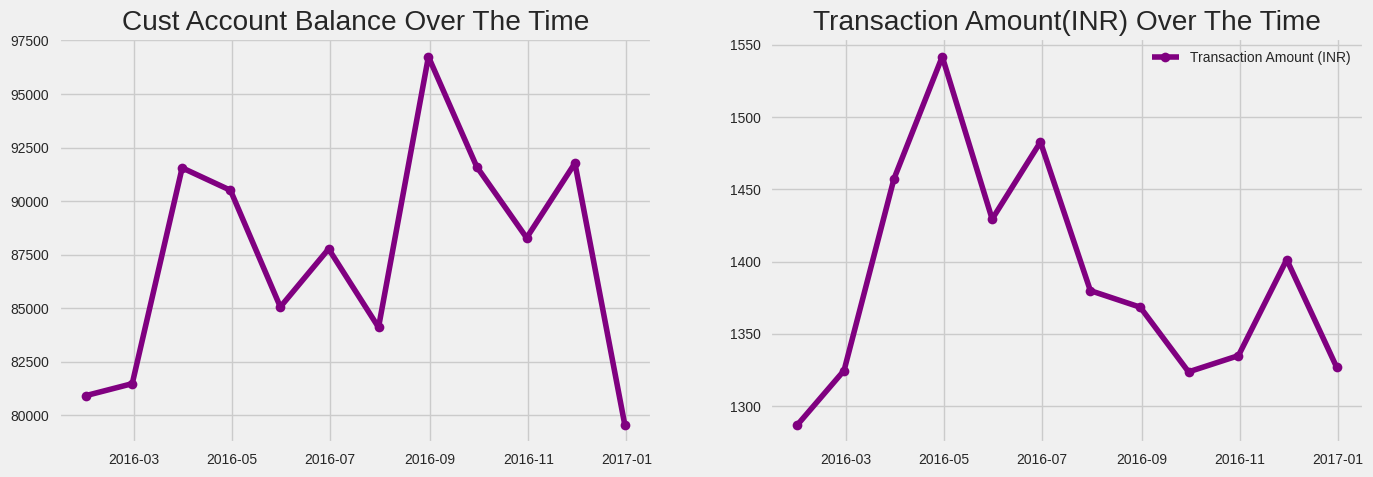

In [ ]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
ax[0].plot(groupbby_month.index,groupbby_month['CustAccountBalance'],color='purple',marker='o',label='Customer Account Balance')
ax[0].set_title('Cust Account Balance Over The Time')
ax[1].plot(groupbby_month.index,groupbby_month['TransactionAmount (INR)'],color='purple',marker='o',label='Transaction Amount (INR)')
ax[1].set_title("Transaction Amount(INR) Over The Time")
plt.legend()

## Feature Engineering

In [ ]:
RMF_data.reset_index(drop=True, inplace = True)
RMF_data.head()

,Frequency,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),CustomerAge,TransactionDate,Recency
0,1,M,CHENNAI,32.44,20.00,27,2016-01-08,1
1,1,M,NIZAMABAD,11397.78,1000.00,45,2016-01-08,1
2,1,M,GURGAON,138758.81,300.00,33,2016-01-08,1
3,1,M,GHAZIABAD,116015.93,346.00,24,2016-01-08,1
4,1,F,NOWGAON,520.93,840.62,23,2016-01-08,1


In [ ]:
RMF_data.drop(columns=['CustLocation','TransactionDate'],inplace=True)
RMF_data['CustGender']=RMF_data['CustGender'].map({'M':1,'F':0})
print(RMF_data.shape)

(784947, 6)


In [ ]:
RMF_data.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,1,1,32.44,20.00,27,1
1,1,1,11397.78,1000.00,45,1
2,1,1,138758.81,300.00,33,1
3,1,1,116015.93,346.00,24,1
4,1,0,520.93,840.62,23,1


In [ ]:
minmax = MinMaxScaler()
standard_scaler = StandardScaler()
RMF_scaled = RMF_data.copy()
RMF_scaled[["Frequency", "CustGender", "Recency"]] = minmax.fit_transform(RMF_data[["Frequency", "CustGender", "Recency"]])
RMF_scaled[["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"]] = standard_scaler.fit_transform(RMF_data[["CustAccountBalance", "TransactionAmount (INR)", "CustomerAge"]])

In [ ]:
RMF_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,0.0,1.0,-0.161603,-0.232143,-0.511594,0.0
1,0.0,1.0,-0.141464,-0.064441,2.187155,0.0
2,0.0,1.0,0.084222,-0.184228,0.387989,0.0
3,0.0,1.0,0.043921,-0.176356,-0.961386,0.0
4,0.0,0.0,-0.160738,-0.091715,-1.111316,0.0


## Modelling

### Subset selection

In [ ]:
RMF_scaled=RMF_scaled.sample(n=75000,random_state=69).reset_index(drop=True)
RMF_scaled.head()

,Frequency,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency
0,0.4,0.0,-0.152422,-0.182631,0.687850,0.364179
1,0.2,0.0,-0.128398,-0.142474,0.387989,0.038806
2,0.0,1.0,-0.079901,-0.062969,-0.661525,0.000000
3,0.0,1.0,-0.156795,-0.218453,0.687850,0.000000
4,0.0,0.0,-0.161383,-0.165575,2.187155,0.000000


### PCA

In [ ]:
# Check for NaN values in the "RMF_scaled" column
nan_values = RMF_scaled.isna().sum()
RMF_scaled.dropna(inplace=True)
nan_values = RMF_scaled.isna().sum()
print("Number of NaN values in RMF_scaled column:", nan_values)


Number of NaN values in RMF_scaled column: Frequency                  0
CustGender                 0
CustAccountBalance         0
TransactionAmount (INR)    0
CustomerAge                0
Recency                    0
dtype: int64


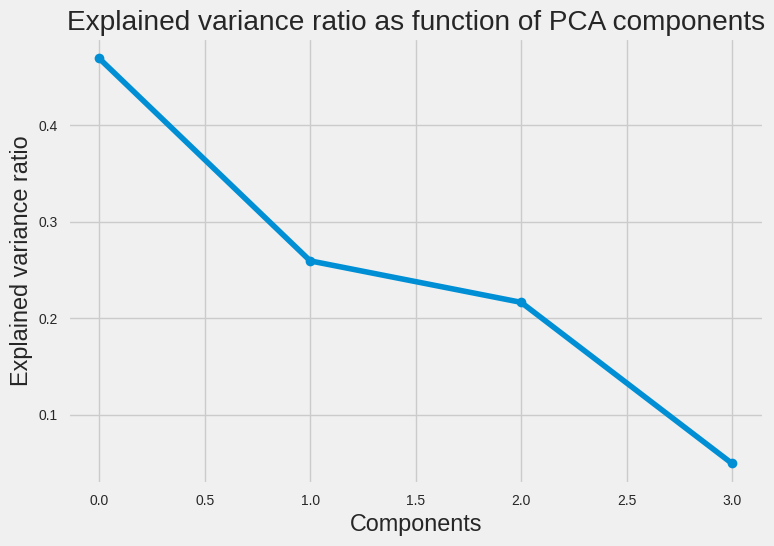

In [ ]:
trial_pca=PCA(n_components=4)
trial_pca.fit(RMF_scaled)
test=trial_pca.transform(RMF_scaled)
plt.plot(list(trial_pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.show()

In [ ]:
RMF_pca=PCA(n_components=3)
reduced_features=RMF_pca.fit_transform(RMF_scaled)
X_principal=pd.DataFrame(reduced_features)
X_principal.columns=['P1','P2', 'P3']

### KMeans

In [ ]:
WCSS = []
silh_scores_kmeans = []
db_scores_kmeans = []

for n_cluster in range(2, 11):
    model_kmeans = KMeans(n_clusters=n_cluster)
    model_kmeans.fit(reduced_features)
    WCSS.append(model_kmeans.inertia_)
    silh_scores_kmeans.append(silhouette_score(reduced_features, model_kmeans.labels_))
    db_scores_kmeans.append(davies_bouldin_score(reduced_features, model_kmeans.labels_))

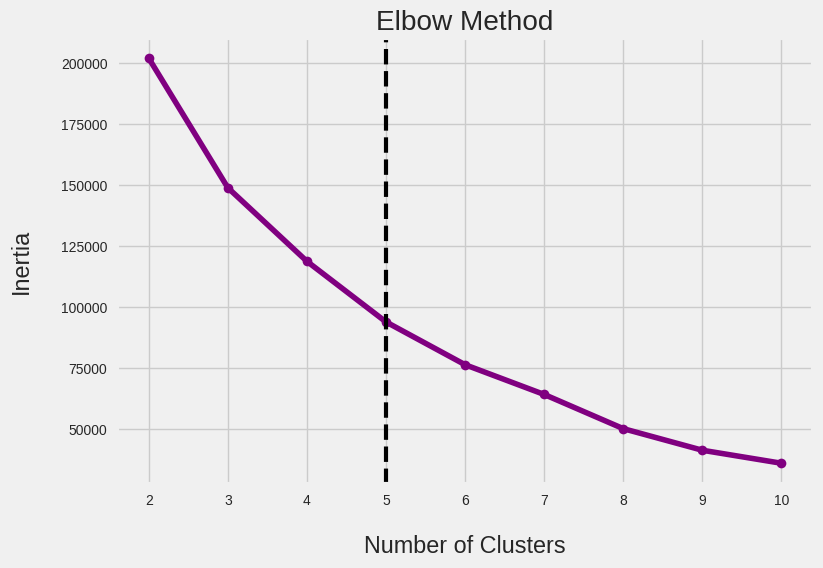

In [ ]:
plt.style.use("fivethirtyeight")
# fig,ax=plt.subplots(1,2,figsize=(20,5))
kl = KneeLocator(range(2,11), WCSS, curve='convex', direction="decreasing")
plt.plot(range(2,11), WCSS,color='purple',marker='o',label='Elbow Method')
plt.xticks(range(2,11))
plt.xlabel("Number of Clusters", labelpad=20)
plt.ylabel("Inertia", labelpad=20)
plt.title("Elbow Method")
plt.axvline(x=kl.elbow, color='black', label='axvline-fullheight', ls='--', linewidth=3)


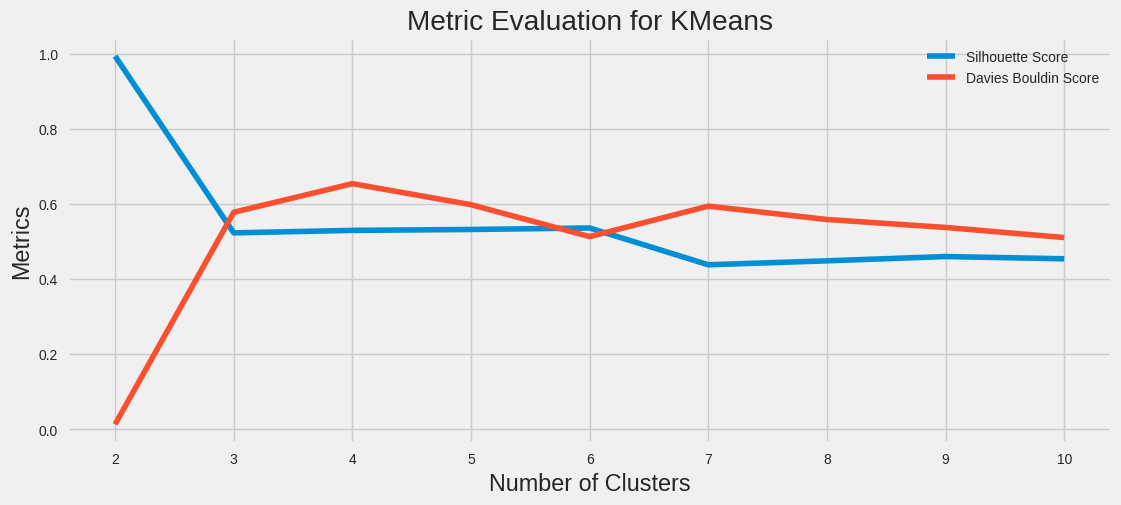

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(2, 11), silh_scores_kmeans, label="Silhouette Score")
plt.plot(range(2, 11), db_scores_kmeans, label="Davies Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Metrics")
plt.title("Metric Evaluation for KMeans")
plt.legend()
plt.show()

In [ ]:
kmeans_set = {"init":"random", "max_iter":300, "random_state":42}
kmeans = KMeans(n_clusters=5 , **kmeans_set)
kmeans.fit(reduced_features)
X_principal['Label']=kmeans.labels_
X_principal.head()

,P1,P2,P3,Label
0,-0.073064,0.483103,-0.525945,1
1,-0.090166,0.248771,-0.317932,1
2,-0.183659,-0.556464,0.310423,0
3,-0.077129,0.470267,-0.573906,1
4,0.134841,1.705032,-1.340588,2


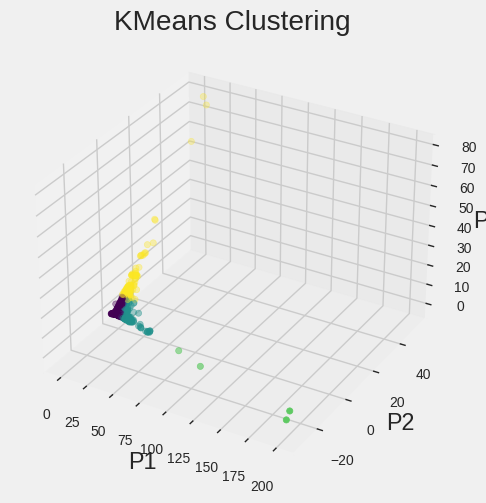

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D('P1','P2', 'P3', c = 'Label', data = X_principal, cmap='viridis',  linewidth=0.5)
#ax.scatter3D(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], label='Cluster Centers')
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')
plt.title('KMeans Clustering')
plt.legend()
plt.show()

### Hierarchical Clustering

In [ ]:
X_principal.drop(columns = ['Label'], inplace = True)
X_principal.head()

,P1,P2,P3
0,-0.073064,0.483103,-0.525945
1,-0.090166,0.248771,-0.317932
2,-0.183659,-0.556464,0.310423
3,-0.077129,0.470267,-0.573906
4,0.134841,1.705032,-1.340588


In [ ]:
X_principal=X_principal.sample(n=10000,random_state=69).reset_index(drop=True)
X_principal.shape

(10000, 3)

### DBScan

In [ ]:
db=DBSCAN(eps=10,min_samples=1000).fit(X_principal)
core_samples_mask=np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_]=True
labels=db.labels_

In [ ]:
X_principal['Label'] = labels
X_principal.head()

,P1,P2,P3,Label
0,-0.092519,0.394292,-0.428684,0
1,-0.273584,-0.688197,0.362825,0
2,0.000077,0.370407,-0.431964,0
3,-0.077104,0.287426,-0.250369,0
4,10.480877,-2.342082,0.993838,0


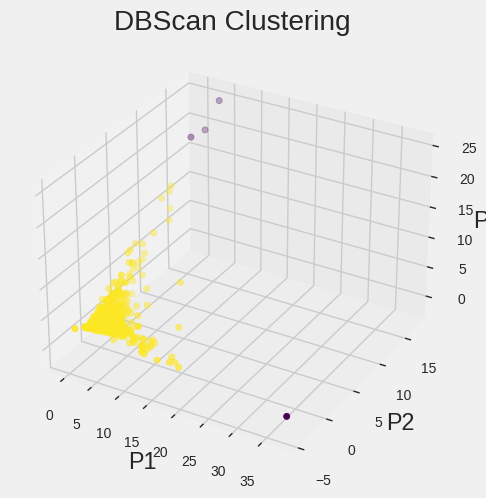

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D('P1','P2', 'P3', c = 'Label', data = X_principal, cmap='viridis',  linewidth=0.5)
#ax.scatter3D(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,2], label='Cluster Centers')
ax.set_xlabel('P1')
ax.set_ylabel('P2')
ax.set_zlabel('P3')
plt.title('DBScan Clustering')
plt.legend()
plt.show()